In [1]:
import sys
sys.path.append('/home/swang597/Documents/Research/Project_heightmap/Utility_projHM')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import os
import numpy as np
import tqdm
import torchvision
from torchvision import datasets, models, transforms
import copy

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

from datetime import date
# from model_3e3d import UNet_3e3d_Img, UNet_3e3d_Vec, UNet_CNN3e3d_2I_1V, UNet_CNN3e3d_2I_1V_lin2
import model_3e3d as mymodel
import glob

torch.manual_seed(1)
np.random.seed(1)

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device is {device}")
wheel_cur = 1
nDT = 5
# read training dataset ----------
foldername_dataPT = f"/home/swang597/Documents/Research/chrono_fork_radu/project_TireTestRig/build/DEMO_OUTPUT/Dataset_4_ML_train/"

inI_NN1_ts_train = torch.load(foldername_dataPT +'Iin_NN1_ts_train.pt')
inI_NN1_ts_test = torch.load(foldername_dataPT +'Iin_NN1_ts_test.pt')
# outV_NN1_ts_train = torch.load(foldername_dataPT +'dF_NN1_ts_train.pt')
# outV_NN1_ts_test = torch.load(foldername_dataPT +'dF_NN1_ts_test.pt')
outV_NN1_ts_train = torch.load(foldername_dataPT +'F_NN1_ts_train.pt')
outV_NN1_ts_test = torch.load(foldername_dataPT +'F_NN1_ts_test.pt')

inI_NN2_ts_train = torch.load(foldername_dataPT +'Iin_NN2_ts_train.pt')
inI_NN2_ts_test = torch.load(foldername_dataPT +'Iin_NN2_ts_test.pt')
inV_NN2_ts_train = torch.load(foldername_dataPT +'Vec_NN2_ts_train.pt')
inV_NN2_ts_test = torch.load(foldername_dataPT +'Vec_NN2_ts_test.pt')

outI_NN2_ts_train = torch.load(foldername_dataPT +'Iout_NN2_ts_train.pt')
outI_NN2_ts_test = torch.load(foldername_dataPT +'Iout_NN2_ts_test.pt')

I10_NN2_ts_train = torch.load(foldername_dataPT +'I10_NN2_ts_train.pt')
I10_NN2_ts_test = torch.load(foldername_dataPT +'I10_NN2_ts_test.pt')

time_train = np.load(foldername_dataPT +'time_train.npy')
time_test = np.load(foldername_dataPT +'time_test.npy')
print("Read data, Done!")
print(inV_NN2_ts_test.size())

device is cuda
Read data, Done!
torch.Size([1650, 2])


inV_NN2_ts_test, z_nm=0.02857648767530918, Vz_nm=0.6425172686576843
inV_NN2_ts_test, z_nm=0.059576019644737244, Vz_nm=0.5822762846946716
inV_NN2_ts_test, z_nm=0.016934216022491455, Vz_nm=0.597592830657959
inV_NN2_ts_test, z_nm=0.04138965532183647, Vz_nm=0.5642163157463074
inV_NN2_ts_test, z_nm=0.025267982855439186, Vz_nm=0.5975770354270935


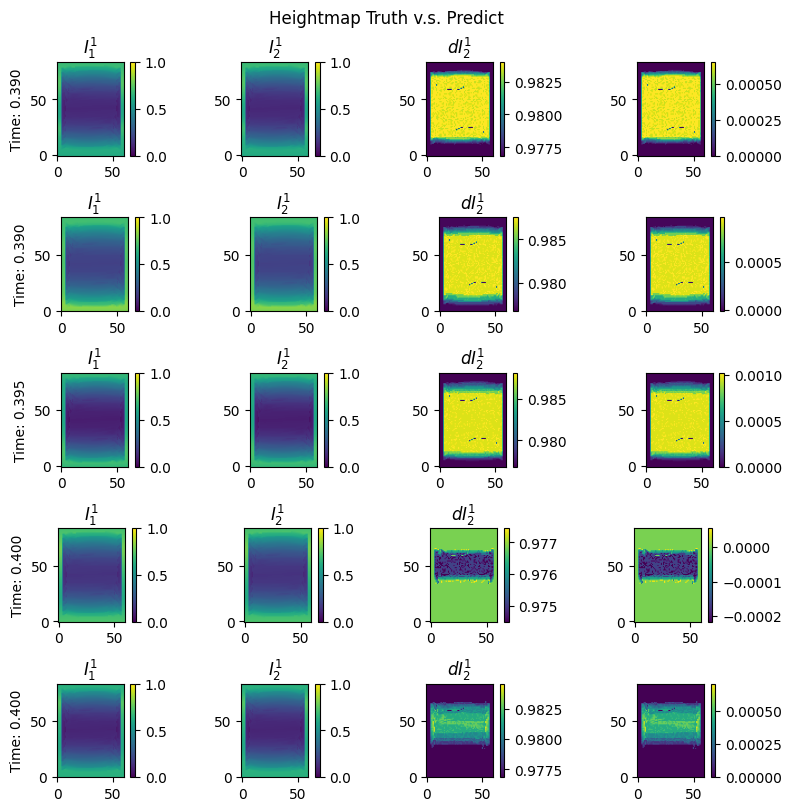

In [56]:
# plot img predict results
rows =5
columns = 2

fig = plt.figure(constrained_layout=True,figsize=(8,8))
fig.suptitle('Heightmap Truth v.s. Predict')

sorted_indices = np.argsort(time_test)
# selected_elements = np.sort(random.sample(range(len(sorted_indices)), 5))
# create 3x1 subfigs
subfigs = fig.subfigures(nrows=rows, ncols=1)
for row, subfig in enumerate(subfigs):
    axs = subfig.subplots(nrows=1, ncols=columns+2)
    idx_plot = sorted_indices[row*10+1210] #sorted_indices[int(row*len(sorted_indices)/rows)]
    I00_test = inI_NN2_ts_test[idx_plot][0]
    dI10_test = outI_NN2_ts_test[idx_plot][0]
    I10_test = I10_NN2_ts_test[idx_plot][0]
    dI10_cal = I10_test - I00_test
    # print(dI10_cal[30][30], dI10_test[30][30])
    err_dI10 = sum(sum(abs(dI10_test - dI10_cal) > 1e-5))
    # print(err_dI10)
    
    # outI_pred = Y_pred[idx_plot][0]
    print(f'inV_NN2_ts_test, z_nm={inV_NN2_ts_test[idx_plot,0]}, Vz_nm={inV_NN2_ts_test[idx_plot,1]}')
    im0 = axs[0].imshow(I00_test, cmap='viridis',origin='lower',vmin=0, vmax=1)
    subfig.colorbar(im0, ax=axs[0])#,  label='Height')
    axs[0].set_ylabel('Time: %.3f'%(time_test[idx_plot]))

    im1 = axs[1].imshow(I10_test, cmap='viridis',origin='lower',vmin=0, vmax=1)
    subfig.colorbar(im1, ax=axs[1])#,  label='Height')
    # axs[1].set_ylabel('Time: %.3f'%(time_test[idx_plot]))

    vmin_test, vmax_test = torch.min(dI10_test), torch.max(dI10_test)
    # print('dI10_test', vmin_test, vmax_test)
    im2 = axs[2].imshow(dI10_test, cmap='viridis',origin='lower',vmin=vmin_test, vmax=vmax_test)
    subfig.colorbar(im2, ax=axs[2])#,  label='Height')
    
    vmin_test, vmax_test = torch.min(dI10_cal), torch.max(dI10_cal)
    # print('dI10_cal', vmin_test, vmax_test)
    im3 = axs[3].imshow(dI10_cal, cmap='viridis',origin='lower',vmin=vmin_test, vmax=vmax_test)
    subfig.colorbar(im3, ax=axs[3])#,  label='Height')
    
    # im2 = axs[2].imshow(outI_pred, cmap='viridis',origin='lower',vmin=vmin_test, vmax=vmax_test)
    # subfig.colorbar(im2, ax=axs[2],  label='Height')
    
    axs[0].title.set_text(r'$I_1^1$')
    axs[1].title.set_text(r'$I_2^1$')
    axs[2].title.set_text(r'$dI_2^1$') #+', Time:%.3f'%(time_output_test[idx_plot]))
    # axs[2].title.set_text(r'$\hat{dI}_2^1$') #+', Time:%.3f'%(time_output_test[idx_plot]))
    
    # axs[0].set_ylabel(f"DT={time_NN2_test[idx_plot]-time_NN2_test[idx_plot]:.3f}")
    
    
# fig.savefig(folder_model+'best_epoch_%d_HM.png' % (best_epoch))


In [46]:
err_dI10 = sum(sum(abs(dI10_test - dI10_cal) > 1e-5))
print((dI10_test - dI10_cal)< 1e-5)
print(err_dI10)


tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])
tensor(5040)


In [37]:
print(dI10_cal)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
